<a href="https://colab.research.google.com/github/Dummy-Bug/StackOverflow-Tag-Predictor/blob/master/1%20Stack%20Overflow%20EDA/SO_Tag_Predictor_self.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression



from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [2]:
# from skmultilearn.adapt import mlknn
# from skmultilearn.problem_transform import ClassifierChain
# from skmultilearn.problem_transform import BinaryRelevance
# from skmultilearn.problem_transform import LabelPowerset

# Stack Overflow: Tag Prediction

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p style='font-size:18px'><b> Description </b></p>
<p>
Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.<br />
<br />
Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.<br />
<br />
</p>

<p style='font-size:18px'><b> Problem Statemtent </b></p>
Suggest the tags based on the content that was there in the question posted on Stackoverflow.

<p style='font-size:18px'><b> Source:  </b> https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/</p>


<h2> 1.2 Source / useful links </h2>

Data Source : https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data <br>
Youtube : https://youtu.be/nNDqbUhtIRg <br>
Research paper : https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tagging-1.pdf <br>
Research paper : https://dl.acm.org/citation.cfm?id=2660970&dl=ACM&coll=DL

<h2> 1.3 Real World / Business Objectives and Constraints </h2>

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

<h1>2. Machine Learning problem </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

Refer: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data
<br>
All of the data is in 2 files: Train and Test.<br />
<pre>
<b>Train.csv</b> contains 4 columns: Id,Title,Body,Tags.<br />
<b>Test.csv</b> contains the same columns but without the Tags, which you are to predict.<br />
<b>Size of Train.csv</b> - 6.75GB<br />
<b>Size of Test.csv</b> - 2GB<br />
<b>Number of rows in Train.csv</b> = 6034195<br />
</pre>
The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).<br />
<br />


__Data Field Explaination__

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br />

<h3>2.1.2 Example Data point </h3>

<pre>
<b>Title</b>:  Implementing Boundary Value Analysis of Software Testing in a C++ program?
<b>Body </b>: <pre><code>
        #include&lt;
        iostream&gt;\n
        #include&lt;
        stdlib.h&gt;\n\n
        using namespace std;\n\n
        int main()\n
        {\n
                 int n,a[n],x,c,u[n],m[n],e[n][4];\n         
                 cout&lt;&lt;"Enter the number of variables";\n         cin&gt;&gt;n;\n\n         
                 cout&lt;&lt;"Enter the Lower, and Upper Limits of the variables";\n         
                 for(int y=1; y&lt;n+1; y++)\n         
                 {\n                 
                    cin&gt;&gt;m[y];\n                 
                    cin&gt;&gt;u[y];\n         
                 }\n         
                 for(x=1; x&lt;n+1; x++)\n         
                 {\n                 
                    a[x] = (m[x] + u[x])/2;\n         
                 }\n         
                 c=(n*4)-4;\n         
                 for(int a1=1; a1&lt;n+1; a1++)\n         
                 {\n\n             
                    e[a1][0] = m[a1];\n             
                    e[a1][1] = m[a1]+1;\n             
                    e[a1][2] = u[a1]-1;\n             
                    e[a1][3] = u[a1];\n         
                 }\n         
                 for(int i=1; i&lt;n+1; i++)\n         
                 {\n            
                    for(int l=1; l&lt;=i; l++)\n            
                    {\n                 
                        if(l!=1)\n                 
                        {\n                    
                            cout&lt;&lt;a[l]&lt;&lt;"\\t";\n                 
                        }\n            
                    }\n            
                    for(int j=0; j&lt;4; j++)\n            
                    {\n                
                        cout&lt;&lt;e[i][j];\n                
                        for(int k=0; k&lt;n-(i+1); k++)\n                
                        {\n                    
                            cout&lt;&lt;a[k]&lt;&lt;"\\t";\n               
                        }\n                
                        cout&lt;&lt;"\\n";\n            
                    }\n        
                 }    \n\n        
                 system("PAUSE");\n        
                 return 0;    \n
        }\n
        </code></pre>\n\n
        <p>The answer should come in the form of a table like</p>\n\n
        <pre><code>       
        1            50              50\n       
        2            50              50\n       
        99           50              50\n       
        100          50              50\n       
        50           1               50\n       
        50           2               50\n       
        50           99              50\n       
        50           100             50\n       
        50           50              1\n       
        50           50              2\n       
        50           50              99\n       
        50           50              100\n
        </code></pre>\n\n
        <p>if the no of inputs is 3 and their ranges are\n
        1,100\n
        1,100\n
        1,100\n
        (could be varied too)</p>\n\n
        <p>The output is not coming,can anyone correct the code or tell me what\'s wrong?</p>\n'
<b>Tags </b>: 'c++ c'
</pre>

<h2>2.2 Mapping the real-world problem to a Machine Learning Problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<p> It is a multi-label classification problem  <br>
<b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. <br>
__Credit__: http://scikit-learn.org/stable/modules/multiclass.html
</p>

<h3>2.2.2 Performance metric </h3>

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://www.kaggle.com/wiki/HammingLoss <br>

<h1> 3. Exploratory Data Analysis </h1>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h2> 3.1 Data Loading and Cleaning </h2>

<h3>3.1.1 Using Pandas with SQLite to Load the data</h3>

In [4]:
from datetime import datetime

dt.datetime.now()

datetime.datetime(2022, 1, 18, 8, 41, 29, 467314)

In [5]:
dt.datetime.now()

datetime.datetime(2022, 1, 18, 8, 41, 31, 154600)

In [ ]:
# Creating db file from csv
# Learn SQL: https://www.w3schools.com/sql/default.asp

if not os.path.isfile('train.db'):

    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db') # creating a database called train.db 
    
    start = dt.datetime.now()
    
    chunksize = 180000 # reading 180k rows at a time 
    j = 0
    index_start = 1
    for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize = chunksize, iterator=True, encoding='utf-8', ):
       
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
      
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

<h3> 3.1.2 Counting the number of rows </h3>

In [ ]:
if os.path.isfile('train.db'):
    start = datetime.now()

    con = sqlite3.connect('train.db') # first connect to the database named train.db 
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    
    # Always remember to close the database

    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Please download the train.db file from drive or run the above cell to genarate train.db file


<h3>3.1.3 Checking for duplicates </h3>

In [ ]:
# Learn SQl: https://www.w3schools.com/sql/default.asp
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

Time taken to run this cell : 0:04:33.560122


In [ ]:
df_no_dup.head()
# we can observe that there are duplicates

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [ ]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions : 1827881 ( 30.2920389063 % )


In [ ]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

In [ ]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:03.169523


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [ ]:
# distribution of number of tags per question
df_no_dup.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568298
5     505158
Name: tag_count, dtype: int64

In [6]:
# Creating a new database with no duplicates
if not os.path.isfile('/content/drive/MyDrive/Case Studies/Stack Overflow Tag Predictor /data/train_no_dup.db'):

    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

else:
  print("File is Already Present")

File is Already Present


In [7]:
# This method seems more appropriate to work with this much data.
# creating the connection with database file.

if os.path.isfile('/content/drive/MyDrive/Case Studies/Stack Overflow Tag Predictor /data/train_no_dup.db'):

    start = datetime.now()
    con   = sqlite3.connect('/content/drive/MyDrive/Case Studies/Stack Overflow Tag Predictor /data/train_no_dup.db')

    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con) # selecting only the tags 
   
    con.close() # closing the connection .
    print("Time taken to run this cell :", datetime.now() - start)

else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:02:57.005153


In [8]:
print(tag_data.head() )

tag_data.shape

                                  Tags
0                                c++ c
1          c# silverlight data-binding
2  c# silverlight data-binding columns
3                             jsp jstl
4                            java jdbc


(4206315, 1)

In [9]:
    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    # Printing first 5 columns from our data frame
    tag_data.head()

    tag_data.shape

(4206314, 1)

<h2> 3.2 Analysis of Tags </h2>

<h3> 3.2.1 Total number of unique tags </h3>

In [10]:
# Importing & Initializing the "CountVectorizer" object, which 
# is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.

vectorizer = CountVectorizer(tokenizer = lambda x: x.split())

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.

tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [11]:
tag_dtm.shape

(4206314, 42048)

In [12]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 4206314
Number of unique tags : 42048


In [13]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


<h3> 3.2.3 Number of times a tag appeared </h3>

In [14]:
tag_dtm.sum(axis=0) # axis = 0 means sum along the rows.
# it will return in the sum in matrix format

matrix([[18, 37,  1, ...,  8, 32,  1]], dtype=int64)

In [15]:
tag_dtm.sum(axis=0).A1 
# it will return the sum in the array 

array([18, 37,  1, ...,  8, 32,  1], dtype=int64)

In [16]:
tags[:5] # seeing first five tags .

['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile']

In [17]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
# Lets now store the document term matrix in a dictionary.

freqs  = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [18]:
# Saving this dictionary to csv files.

if not os.path.isfile('/content/drive/MyDrive/Case Studies/Stack Overflow Tag Predictor /data/tag_counts_dict_dtm.csv'):
    with open('/content/drive/MyDrive/Case Studies/Stack Overflow Tag Predictor /data/tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("/content/drive/MyDrive/Case Studies/Stack Overflow Tag Predictor /data/tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [19]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False) # sorting on the basis of COUNTS .

print(tag_df_sorted.head(3))

tag_counts    = tag_df_sorted['Counts'].values # converting to list 

print(tag_counts)

       Tags  Counts
4337     c#  331505
18069  java  299414
27249   php  284103
[331505 299414 284103 ...      1      1      1]


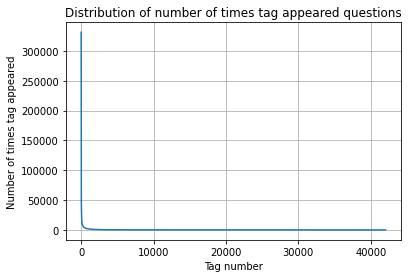

In [20]:
plt.plot(tag_counts)

plt.title("Distribution of number of times tag appeared questions")

plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")

plt.show()

In [21]:
tag_counts[0:25:5]

array([331505, 221533, 122769,  95160,  62023])

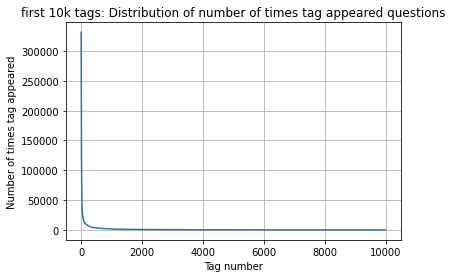

Total Number of Tags =  400 
 [331505  44829  22429  17728  13364  11162  10029   9148   8054   7151
   6466   5865   5370   4983   4526   4281   4144   3929   3750   3593
   3453   3299   3123   2989   2891   2738   2647   2527   2431   2331
   2259   2186   2097   2020   1959   1900   1828   1770   1723   1673
   1631   1574   1532   1479   1448   1406   1365   1328   1300   1266
   1245   1222   1197   1181   1158   1139   1121   1101   1076   1056
   1038   1023   1006    983    966    952    938    926    911    891
    882    869    856    841    830    816    804    789    779    770
    752    743    733    725    712    702    688    678    671    658
    650    643    634    627    616    607    598    589    583    577
    568    559    552    545    540    533    526    518    512    506
    500    495    490    485    480    477    469    465    457    450
    447    442    437    432    426    422    418    413    408    403
    398    393    388    385    381    378    3

In [22]:
plt.plot(tag_counts[0:10000])

plt.title('first 10k tags: Distribution of number of times tag appeared questions')

plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")

plt.show()
print("Total Number of Tags = ",len(tag_counts[0:10000:25]),"\n", tag_counts[0:10000:25]) # selecting first 10k in the steps of 25 

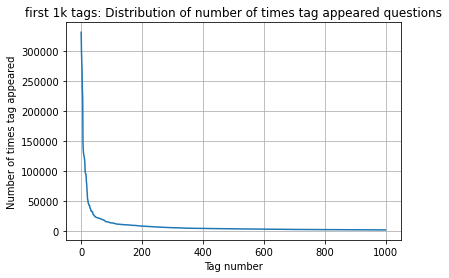

200 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483
   3453   3427   3396   3363   3326   3299   3272   3232   3196   3168
   3123   3094   3073   3050   3012   2989   2984   2953   2934   2903
   2891   2844   2819   2784   2754   2738   2726   2708   2681   2669
   2647   2621   2604   2594   2556   2527   2510   2482   2460   2444
  

In [23]:
plt.plot(tag_counts[0:1000]) # first 1k tags

plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()

plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")

plt.show()
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

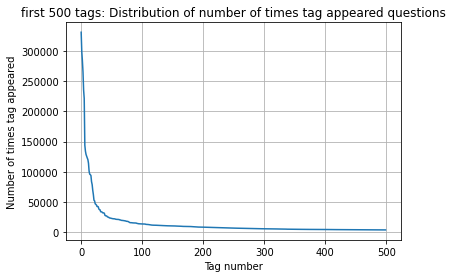

100 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483]


In [24]:
plt.plot(tag_counts[0:500])

plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()

plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")

plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

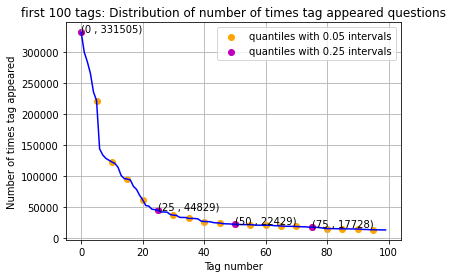

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [25]:
plt.plot(tag_counts[0:100], c ='b') # first 100 tags
plt.scatter(x = list(range(0,100,5)), y = tag_counts[0:100:5], c ='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()

plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")

plt.legend()
plt.show()

print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [26]:
# print(tag_df.head(3))
# tag_df[tag_df.Counts > 10000].Tags
tag_df[tag_df['Counts'] > 10000].Tags

15            .htaccess
22                 .net
466      actionscript-3
918                ajax
1001          algorithm
              ...      
40946               wpf
41194              xaml
41245             xcode
41395               xml
41882    zend-framework
Name: Tags, Length: 153, dtype: object

In [27]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list, as tags > 100k will also be greater than 10k.
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


<b>Observations:</b><br />
1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

<h3> 3.2.4 Tags Per Question </h3>

In [28]:
# Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis = 1).tolist() # sum along columns to get the number of tags in question .
# Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206314 datapoints.
[3, 4, 2, 2, 3]


In [29]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))

print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899440


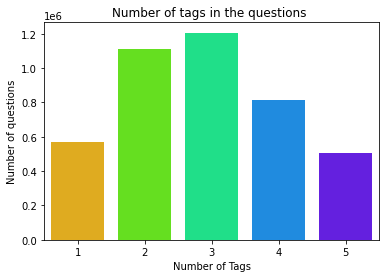

In [30]:
sns.countplot(tag_quest_count, palette ='gist_rainbow')

plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")

plt.show()

<b>Observations:</b><br />
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

<h3>3.2.5 Most Frequent Tags </h3>

In [31]:
result

{'.a': 18,
 '.app': 37,
 '.asp.net-mvc': 1,
 '.aspxauth': 21,
 '.bash-profile': 138,
 '.class-file': 53,
 '.cs-file': 14,
 '.doc': 47,
 '.drv': 1,
 '.ds-store': 8,
 '.each': 184,
 '.emf': 33,
 '.exe': 27,
 '.exe.config': 1,
 '.hgtags': 6,
 '.htaccess': 14884,
 '.htpasswd': 61,
 '.ico': 10,
 '.lib': 20,
 '.lrc': 4,
 '.mobi': 2,
 '.mov': 16,
 '.net': 114087,
 '.net-1.0': 19,
 '.net-1.1': 218,
 '.net-2.0': 1661,
 '.net-3.0': 55,
 '.net-3.5': 3693,
 '.net-4.0': 5020,
 '.net-4.0-beta-2': 16,
 '.net-4.0-rc1': 6,
 '.net-4.5': 695,
 '.net-assembly': 516,
 '.net-authorization': 2,
 '.net-bcl': 2,
 '.net-bugs': 1,
 '.net-cf-3.5': 61,
 '.net-client-profile': 53,
 '.net-compact': 1,
 '.net-framework': 235,
 '.net-framework-source': 15,
 '.net-framework-version': 73,
 '.net-gadgeteer': 12,
 '.net-install': 7,
 '.net-internals': 4,
 '.net-interview': 3,
 '.net-micro-framework': 103,
 '.net-reflector': 24,
 '.net-remoting': 126,
 '.net-security': 13,
 '.net-services': 11,
 '.net2.0': 5,
 '.net3.5': 3

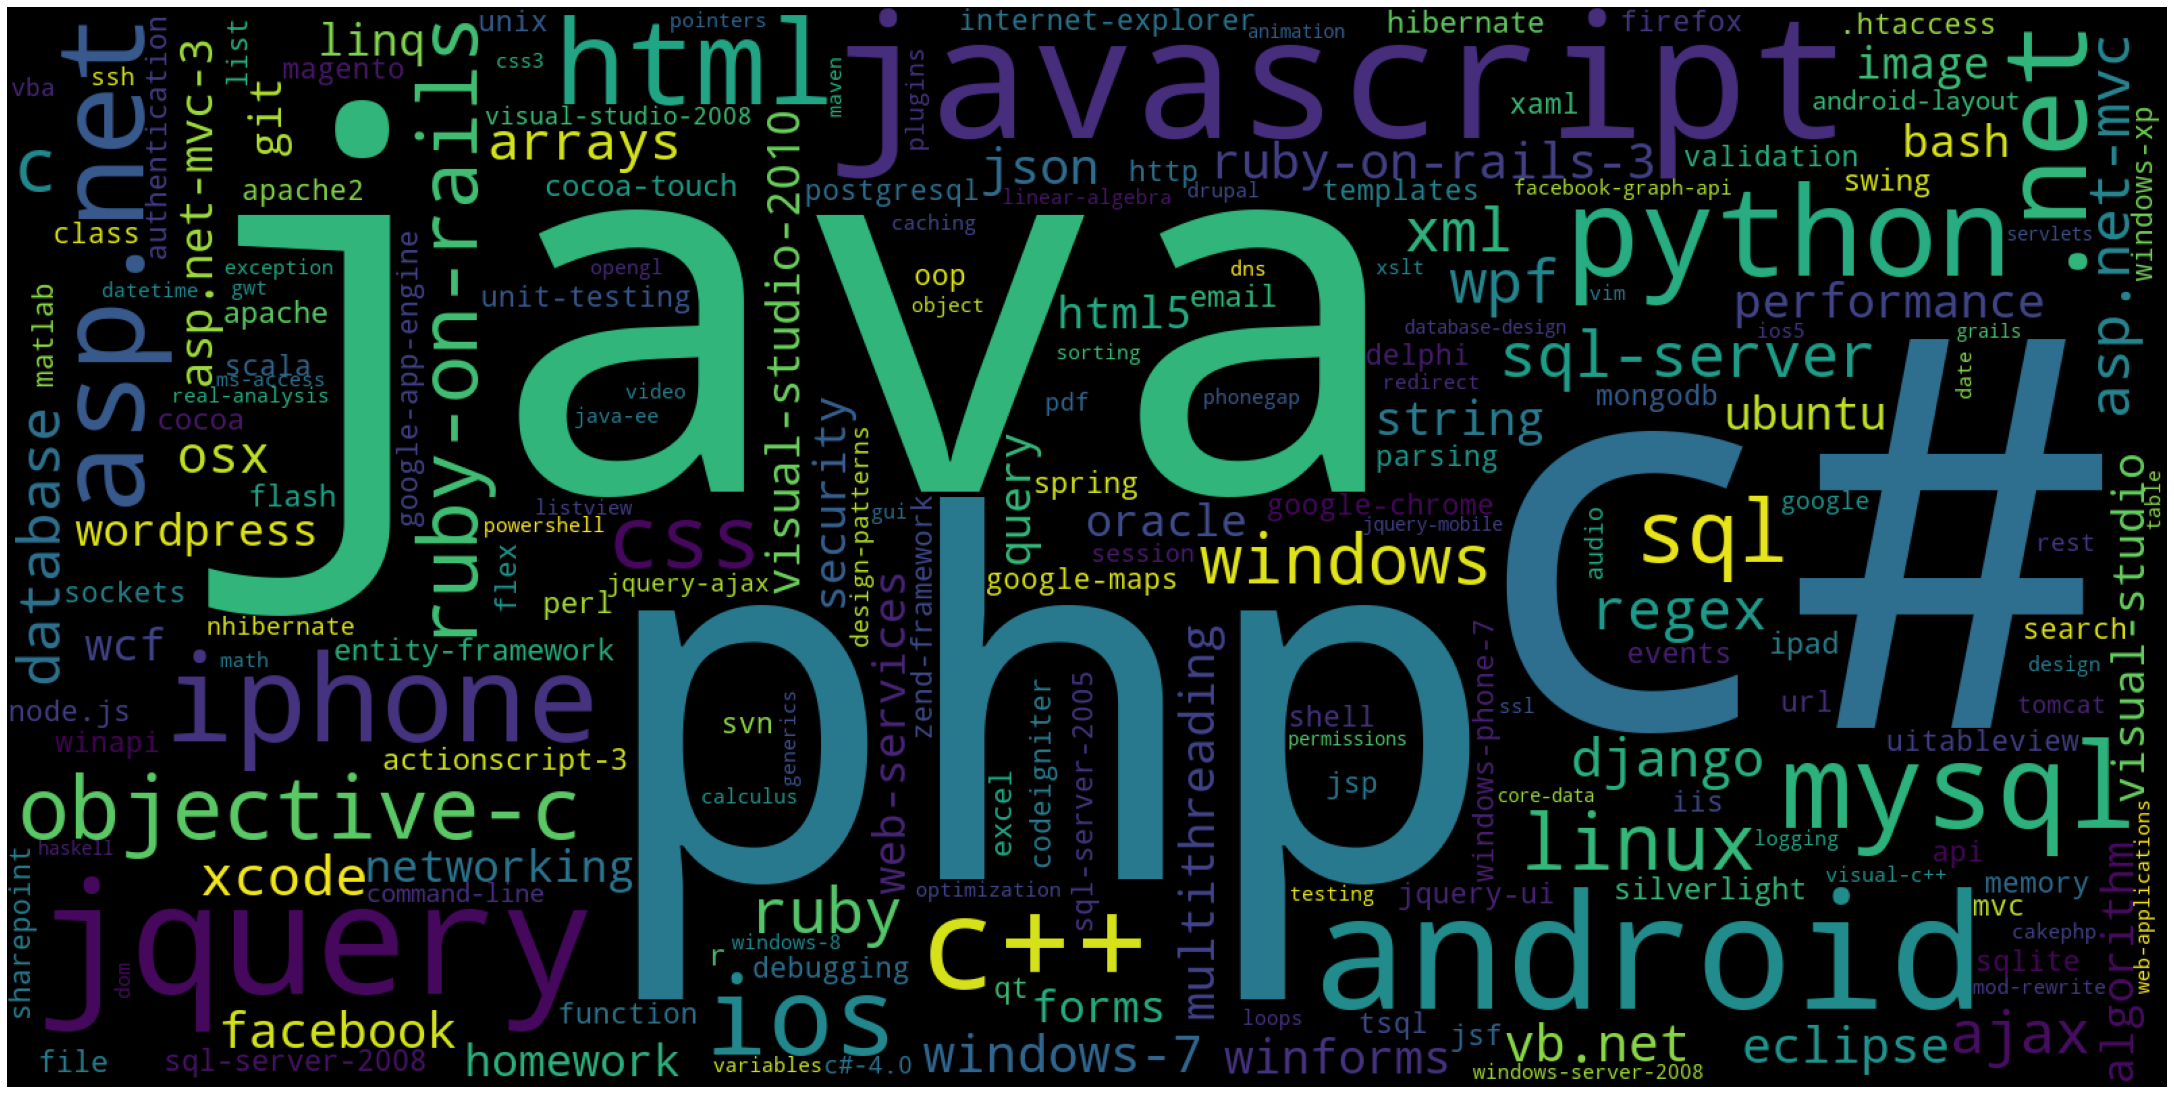

Time taken to run this cell : 0:00:05.610233


In [32]:
# Ploting word cloud

start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'

tup = dict(result.items())

# Initializing WordCloud using frequencies of tags.

wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))

plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")

plt.show()

print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

<h3> 3.2.6 The top 20 tags </h3>

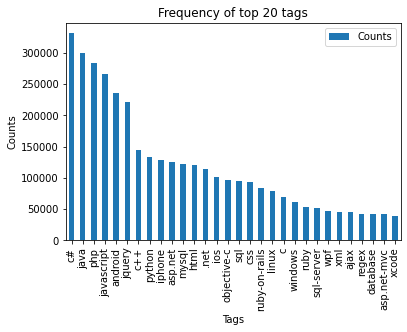

In [33]:
i = np.arange(30)

tag_df_sorted.head(30).plot(kind='bar')

plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])

plt.xlabel('Tags')
plt.ylabel('Counts')

plt.show()

<b>Observations:</b><br />
1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

<h3> 3.3 Cleaning and preprocessing of Questions </h3>

<h3> 3.3.1 Preprocessing </h3>

<ol> 
    <li> Sample 1M data points </li>
    <li> Separate out code-snippets from Body </li>
    <li> Remove Special characters from Question title and description (not in code)</li>
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [34]:
  >>> import nltk
  >>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [35]:
def striphtml(data):

    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data)) # replace all HTML tags </> with blank .
  
    return cleantext

stop_words = set(stopwords.words('english'))
stemmer    = SnowballStemmer("english")

In [36]:
text = 'Hii , is this a <html> tag ?'

striphtml(text)

'Hii , is this a   tag ?'

In [37]:
# http://www.sqlitetutorial.net/sqlite-python/create-tables/

def create_connection(db_file):

    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file) # connecting to the database 
        return conn
   
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):

    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)

    except Error as e:
        print(e)
        
def checkTableExists(dbcon):

    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type = 'table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables = table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [38]:
%%time 
# http://www.sqlitetutorial.net/sqlite-delete/ 

# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table

start = datetime.now()

read_db  = '/content/drive/MyDrive/Case Studies/Stack Overflow Tag Predictor /data/train_no_dup.db'

if os.path.isfile(read_db):
    conn_r = create_connection(read_db) # creating connection to train_no_dup database.

    if conn_r is not None:
        reader = conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 40000;") # selecting only 40k points as per 
                                                                                                    # my system's configurations .

CPU times: user 16.2 s, sys: 9.67 s, total: 25.9 s
Wall time: 1min 55s


In [39]:
write_db = '/content/Processed.db' 

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)

    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer = conn_w.cursor()
    
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:01:55.822623


__ we create a new data base to store the sampled and preprocessed questions __

In [40]:
title = 'Hello !! Python Programming'

print(title.encode('utf-8'))

# unicode string
string = 'pythön!' # Introduced some special characters 

# print string
print('The string is:', string)

# default encoding to utf-8
string_utf = string.encode()

# print result
print('The encoded version is:', string_utf)


b'Hello !! Python Programming'
The string is: pythön!
The encoded version is: b'pyth\xc3\xb6n!'


In [41]:
question = "Hey , how are you doing ?"
question = re.sub(r'[^A-Za-z]+',' ',question)

print(question)

Hey how are you doing 


In [42]:
  >>> import nltk
  >>> nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [43]:
# http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/

# https://pynative.com/python-cursor-fetchall-fetchmany-fetchone-to-read-rows-from-table/

start = datetime.now()

preprocessed_data_list = []

reader.fetchone()
questions_with_code = 0

len_pre = 0 # length of question before pre-processing
len_post= 0 # length of question after  pre-processing 

questions_proccesed = 0

for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code +=1
        is_code = 1

    x = len(question) + len(title)
    len_pre +=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags = re.DOTALL))

    question = re.sub('<code>(.*?)</code>', '', question, flags = re.MULTILINE|re.DOTALL)
    question = striphtml(question.encode('utf-8')) # cleaned the text 

    title = title.encode('utf-8')

    question = str(title)+" "+str(question) # combining text and title together.
    question = re.sub(r'[^A-Za-z]+',' ',question)  # removing anything which is not in these square brackets 
    words    = word_tokenize(str(question.lower()))

    # Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question =' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j) != 1 or j =='c'))

    len_post += len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)

    if (questions_proccesed%10000 == 0):
        print("number of questions completed = ",questions_proccesed)

no_dup_avg_len_pre  = (len_pre*1.0)/questions_proccesed
no_dup_avg_len_post = (len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed =  10000
number of questions completed =  20000
number of questions completed =  30000
Avg. length of questions(Title+Body) before processing: 1172
Avg. length of questions(Title+Body) after processing: 325
Percent of questions containing code: 57
Time taken to run this cell : 0:00:57.260871


In [44]:
# dont forget to close the connections, or else you will end up with locks

conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [45]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)

    if conn_r is not None:

        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")

        print("Questions after preprocessed")
        print('='*100)

        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)


Questions after preprocessed
('ae encrypt decrypt c creat applic save privaci document ni want save file encrypt format search googl ae encrypt decrypt alto c languag abl find standard algorithm implement ae anyon suggest ae enc dec c pleas would like use algorithm android iphon',)
----------------------------------------------------------------------------------------------------
('concaten struct char array struct use internet applic look like basic tri take structur turn packet sent must correspond length everyth could would like nstruct queri feel like relat simpl question probabl answer cast data type think bit harder also tri use sprintf would turn null actual would becom ascii charact',)
----------------------------------------------------------------------------------------------------
('unicod issu html titl question mark tri pars titl follow webpag http kid blogger de stori use apach common lang stringescapeutil escapehtml method titl element get follow howev display webpag u

In [46]:
reader.fetchone()

In [47]:
conn_r.commit()
conn_r.close()

In [48]:
# Taking 1 Million entries to a dataframe.

write_db = '/content/drive/MyDrive/Case Studies/Stack Overflow Tag Predictor /data/Processed.db'

if os.path.isfile(write_db):
    
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
# "SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 40000;"
conn_r.commit()
conn_r.close()

In [51]:
preprocessed_data.head()

,question,tags
0,chang cpu soni vaio pcg grx tri everywher find...,cpu motherboard sony-vaio replacement disassembly
1,display size grayscal qimag qt abl display ima...,c++ qt qt4
2,datagrid selecteditem set back null eventtocom...,mvvm silverlight-4.0
3,filter string collect base listview item resol...,c# winforms string listview collections
4,disabl home button without use type keyguard c...,android android-layout android-manifest androi...


In [52]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 999999
number of dimensions : 2


In [54]:
import pickle

path = '/content/drive/MyDrive/Case Studies/Stack Overflow Tag Predictor /SO_EDA.csv'

preprocessed_data.to_pickle(path) # saving the EDA file 